# Wykorzystanie rozkładów macierzy do rozwiązywania oznaczonych układów równań

Poznane na wykładzie rozkłady (faktoryzacje) macierzy możemy wykorzystać do rozwiązywania układów równań liniowych. Dzięki wykorzystaniu specjalnych własności macierzy występujących w rozkładzie jesteśmy w stanie w łatwiejszy sposób odwrócić macierz i tym samym zminimalizować błąd.


**Zadanie 1.**

Rozważmy układ równań $Ax=b$, w którym:
* $A$ jest macierzą Hilberta o wymiarach 15x15.
* $A$ jest macierzą wartości losowych z przedziału $[0,100]$ o wymiarach 100x100,  1000x1000 i 1000000x1000000.
* $b$ jest wektorem wartości losowych, odpowiednio, o wymiarach 15x1, 100x1, 1000x1 i 1000000x1.

1. Oblicz współczynnik uwarunkowania macierzy $A$ i oceń jej uwarunkowanie.
2. Rozwiąż układ równań następującymi metodami:
    * z użyciem jawnej odwrotności $A$.
    * korzystając z rozkładu [LU](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.lu.html) (uwaga na macierz permutacji!):
        * z wykorzystaniem odwrotności L i U.
        * z użyciem jedynie odwrotności i metody podstawiania wstecznego.
    * korzystając z rozkładu [QR](https://numpy.org/doc/stable/reference/generated/numpy.linalg.qr.html):
        * z wykorzystaniem odwrotności Q i R.
        * z użyciem jedynie odwrotności Q i metody podstawiania wstecznego.
    * za pomocą jednej z metod iteracyjnych z poprzedniego ćwiczenia.
    * za pomocą metody [`solve`](https://numpy.org/doc/stable/reference/generated/numpy.linalg.solve.html) z pakietu NumPy.
3. Porównaj otrzymane wyniki. W tym celu oblicz normy z residuuów otrzymanych dla każdego z rozwiązań. Którą z metod cechuje najwyższa dokladność?
4. Przeprowadź porównanie wydajności ww. metod. Zmierz czas wykonania każdej metody. Aby otrzymać bardziej sensowny wynik należy powtórzyć obliczenia w pętli (np. 100 lub 1000 razy) i uśrednić wynik. Do pomiaru czasu wykonania możesz wykorzystać pakiet `time`.
Wskazówka: Do rozwiązania układu z macierzą trójkątną możesz wykorzystać funkcję [`scipy.linalg.solve_triangular`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.solve_triangular.html).

        
        


In [2]:
import numpy as np
import scipy.linalg

In [3]:
from typing import Optional

ITERATION_LIMIT = 1000

def strictly_diagonal_dominant(A: np.ndarray) -> bool:
    for i in range(A.shape[0]):
        fake_row = np.zeros((1, A.shape[1]))
        fake_row[0, i] = A[i, i]
        if np.sum(fake_row) < np.sum(A[i]-fake_row):
            return False
        
    return True

def solve_gauss_seidel(A: np.ndarray, b:np.ndarray) -> Optional[np.ndarray]:
    if not strictly_diagonal_dominant(A):
        print("Matrix A is not strictly diagonal dominant!")

    L = np.tril(A,-1)
    D = np.diag(np.diag(A))
    U = np.triu(A,1)
    x = np.ones(b.shape)

    L_D_inv = np.linalg.inv(L+D)
    T_g = -L_D_inv@U

    for _ in range(ITERATION_LIMIT):
        x_new = T_g@x+L_D_inv@b
        if np.allclose(x, x_new, atol=1e-10, rtol=0):
            return x_new
        else: 
            x = x_new

    print("ITERATION LIMIT")
    return x

In [4]:
A_hilbert = scipy.linalg.hilbert(15)
A_random = np.random.rand(100, 100)*100
b_15 = np.random.rand(15, 1)
b_100 = np.random.rand(100, 1)

print(f"cond(A_hilbert) = {np.linalg.cond(A_hilbert)}")
print(f"cond(A_random) = {np.linalg.cond(A_random)}")

x_hilbert_real = np.linalg.solve(A_hilbert, b_15)
x_random_real = np.linalg.solve(A_random, b_100)

cond(A_hilbert) = 3.67568286586649e+17
cond(A_random) = 8886.816466821936


In [5]:
from time import time


def solve_inverse(A: np.ndarray, b: np.ndarray) -> np.ndarray:
    # A x = b -> x = A^-1 b

    return np.linalg.inv(A)@b

time_start = time()
for _ in range(1000):
    x_hilbert_inverse = solve_inverse(A_hilbert, b_15)
    x_random_inverse = solve_inverse(A_random, b_100)
time_end = time()
print(f'time: {(time_end-time_start)/2000}s')

residuum_hilbert_inverse = np.linalg.norm(A_hilbert@x_hilbert_inverse-b_15)
residuum_random_inverse = np.linalg.norm(A_random@x_random_inverse-b_100)

print('residuum_hilbert_inverse: ', residuum_hilbert_inverse, 'residuum_random_inverse: ', residuum_random_inverse)

time: 0.0010492534637451172s
residuum_hilbert_inverse:  1.9828441579377807 residuum_random_inverse:  4.0560066625884576e-13


In [6]:

def solve_LU(A: np.ndarray, b:np.ndarray) -> np.ndarray:
    P, L, U = scipy.linalg.lu(A)

    # P a = b -> a = P^T b
    # L c = a
    # U x = c

    a = P.T @ b
    c = scipy.linalg.solve_triangular(L, a, lower=True, unit_diagonal=True)
    x = scipy.linalg.solve_triangular(U, c)

    return x

time_start = time()
for _ in range(1000):
    x_hilbert_LU = solve_LU(A_hilbert, b_15)
    x_random_LU = solve_LU(A_random, b_100)
time_end = time()
print(f'time: {(time_end-time_start)/2000}s')

residuum_hilbert_LU = np.linalg.norm(A_hilbert@x_hilbert_LU-b_15) 
residuum_random_LU = np.linalg.norm(A_random@x_random_LU-b_100)

print('residuum_hilbert_LU: ', residuum_hilbert_LU, 'residuum_random_LU: ', residuum_random_LU)

time: 0.00018768763542175294s
residuum_hilbert_LU:  1.173272554312819 residuum_random_LU:  2.7776508748481104e-13


In [7]:
def solve_QR(A: np.ndarray, b:np.ndarray) -> np.ndarray:
    Q, R = np.linalg.qr(A)

    # Q a = b
    # R x = a

    a = np.linalg.solve(Q, b)
    x = np.linalg.solve(R, a)

    return x

time_start = time()
for _ in range(1000):
    x_hilbert_QR = solve_QR(A_hilbert, b_15)
    x_random_QR = solve_QR(A_random, b_100)
time_end = time()
print(f'time: {(time_end-time_start)/2000}s')

residuum_hilbert_QR = np.linalg.norm(A_hilbert@x_hilbert_QR-b_15) 
residuum_random_QR = np.linalg.norm(A_random@x_random_QR-b_100) 

print('residuum_hilbert_QR: ', residuum_hilbert_QR, 'residuum_random_QR: ', residuum_random_QR)

time: 0.0008798774480819702s
residuum_hilbert_QR:  1.2177521317869946 residuum_random_QR:  1.671584098244607e-13


In [8]:
time_start = time()
for _ in range(1000):
    x_hilbert_solve = np.linalg.solve(A_hilbert, b_15)
    x_random_solve = np.linalg.solve(A_random, b_100)
time_end = time()
print(f'time: {(time_end-time_start)/2000}s')

residuum_hilbert_solve = np.linalg.norm(A_hilbert@x_hilbert_solve-b_15) 
residuum_random_solve = np.linalg.norm(A_random@x_random_solve-b_100) 

print('residuum_hilbert_solve: ', residuum_hilbert_solve, 'residuum_random_solve: ', residuum_random_solve)

time: 4.350149631500244e-05s
residuum_hilbert_solve:  1.4030421825203525 residuum_random_solve:  2.7906561618450527e-13


In [9]:
x_hilbert_gauss = solve_gauss_seidel(A_hilbert, b_15)
x_random_gauss = solve_gauss_seidel(A_random, b_100)

if x_hilbert_gauss is not None:
    residuum_hilbert_gauss = np.linalg.norm(A_hilbert@x_hilbert_gauss-b_15) 
if x_random_gauss is not None:
    residuum_random_gauss = np.linalg.norm(A_random@x_random_gauss-b_100) 

if x_hilbert_gauss is not None and x_random_gauss is not None:
    print('residuum_hilbert_gauss: ', residuum_hilbert_gauss, 'residuum_random_gauss: ', residuum_random_gauss)

Matrix A is not strictly diagonal dominant!
ITERATION LIMIT
Matrix A is not strictly diagonal dominant!
ITERATION LIMIT
residuum_hilbert_gauss:  0.8391928014257719 residuum_random_gauss:  nan


C:\Users\marci\AppData\Local\Temp\ipykernel_30288\2311429724.py:27: RuntimeWarning: overflow encountered in matmul
  x_new = T_g@x+L_D_inv@b
C:\Users\marci\AppData\Local\Temp\ipykernel_30288\2311429724.py:27: RuntimeWarning: invalid value encountered in matmul
  x_new = T_g@x+L_D_inv@b


# Interpolacja

**Zadanie 2.**

Przeprowadź interpolacje poniższych funkcji $f(x)$ za pomocą wielomianów interpolacyjnych Lagrange'a ([`scipy.interpolate.lagrange`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.lagrange.html)). Stwórz wykresy funkcji interpolacyjnych i zaznacz na nich punkty, w ktorych dokonano oceny wartości funkcji.

Pierwsza funkcja:

* $f(0) = 1$,
* $f(0.25) = 1.64872$,
* $f(0.5) = 2.71828$,
* $f(0.75) = 4.48169.$

Oblicz $f(0.43)$.

Druga funkcja:

* $f_2(0.1) = 0.62049958$,
* $f_2(0.2) = -0.28398668$,
* $f_2(0.3) = 0.00660095$,
* $f_2(0.4) = 0.24842440$. 

Oblicz $f_2(0.25)$.

L(0.43) = np.float64(2.360604734079999)


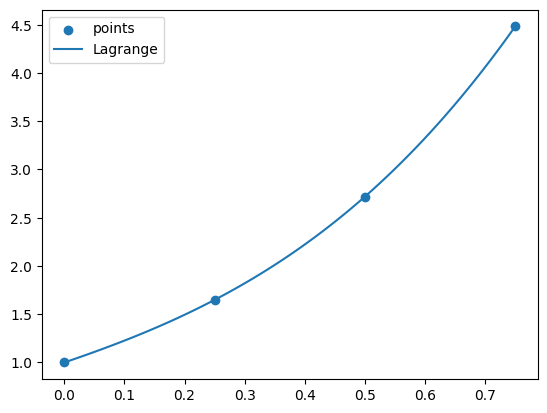

In [10]:
import scipy.interpolate
import numpy as np
import matplotlib.pyplot as plt

x = [0, 0.25, 0.5, 0.75]
y = [1, 1.64872, 2.71828, 4.48169]

L = scipy.interpolate.lagrange(x, y)
print(f'{L(0.43) = }')

plt.scatter(x, y, label="points")
x_plot = np.linspace(min(x), max(x), 100)
plt.plot(x_plot, [L(x) for x in x_plot], label="Lagrange")
plt.plot()
plt.legend()
plt.show()

L(0.25) = np.float64(-0.21033722187500237)


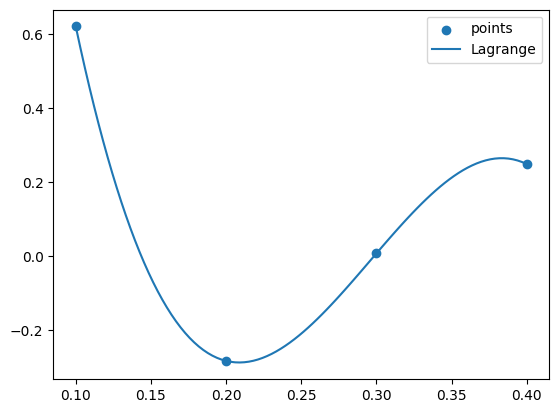

In [11]:
x= [0.1, 0.2, 0.3, 0.4]
y = [0.62049958, -0.28398668, 0.00660095, 0.24842440]

L = scipy.interpolate.lagrange(x, y)
print(f'{L(0.25) = }')

plt.scatter(x, y, label="points")
x_plot = np.linspace(min(x), max(x), 100)
plt.plot(x_plot, [L(x) for x in x_plot], label="Lagrange")
plt.plot()
plt.legend()
plt.show()

***Zadanie 3.***

Rozważmy funkcję $f(x)=\frac{1}{25x^2+1}$. 

Przeprowadź interpolacje funkcji $f$ w przedziale $[-2,2]$ wielomianem Lagrange'a oraz funkcjami sklejanymi 3 stopnia w:
- 21 równoodległych węzłach,
- 21 węzłach [Czebyszewa](https://pl.wikipedia.org/wiki/Węzły_Czebyszewa).

**Wskazówka** Interpolację funkcjami sklejanymi możesz przeprowadzić za pomocą funkcji [`interp1d`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp1d.html#scipy.interpolate.interp1d).

Umieść wielomian interpolacyjny, oryginalną funkcję $f$ oraz węzly interpolacyjne na wspólnym wykresie (jeden wykres dla metody Lagrange'a oraz jeden dla funkcji sklejanych). Porównaj otrzymane rezultaty. Przeprowadź te same działania dla przedziału $x\in[-5,5]$. Jakie problemy możesz zauważyć na otrzymanych wykresach?

In [12]:
def f(x: float) -> float:
    return 1/(25*(x**2)+1)

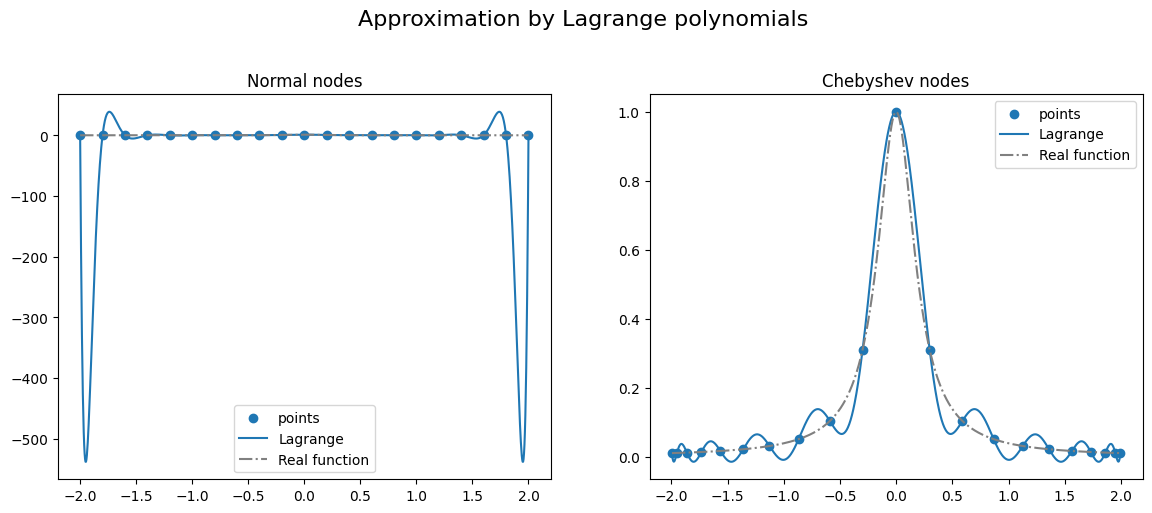

In [13]:
import math

x_normal = np.linspace(-2, 2, 21)
y_normal = f(x_normal)
L_normal = scipy.interpolate.lagrange(x_normal, y_normal)

n = 21
x_chebyshev = np.array([2*math.cos(np.pi*(2*k+1)/(2*n)) for k in range(n)])
y_chebyshev = f(x_chebyshev)
L_chebyshev = scipy.interpolate.lagrange(x_chebyshev, y_chebyshev)

plt.figure(figsize=(14, 5))
plt.suptitle('Approximation by Lagrange polynomials', fontsize=16, y=1.05)

plt.subplot(1, 2, 1)
plt.title('Normal nodes')
plt.scatter(x_normal, y_normal, label="points")
x_plot = np.linspace(min(x_normal), max(x_normal), 1000)
plt.plot(x_plot, L_normal(x_plot), label="Lagrange")
plt.plot(x_plot, f(x_plot), label="Real function", linestyle='-.', color='gray')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('Chebyshev nodes')
plt.scatter(x_chebyshev, y_chebyshev, label="points")
x_plot = np.linspace(min(x_chebyshev), max(x_chebyshev), 1000)
plt.plot(x_plot, L_chebyshev(x_plot), label="Lagrange")
plt.plot(x_plot, f(x_plot), label="Real function", linestyle='-.', color='gray')
plt.legend()
plt.show()

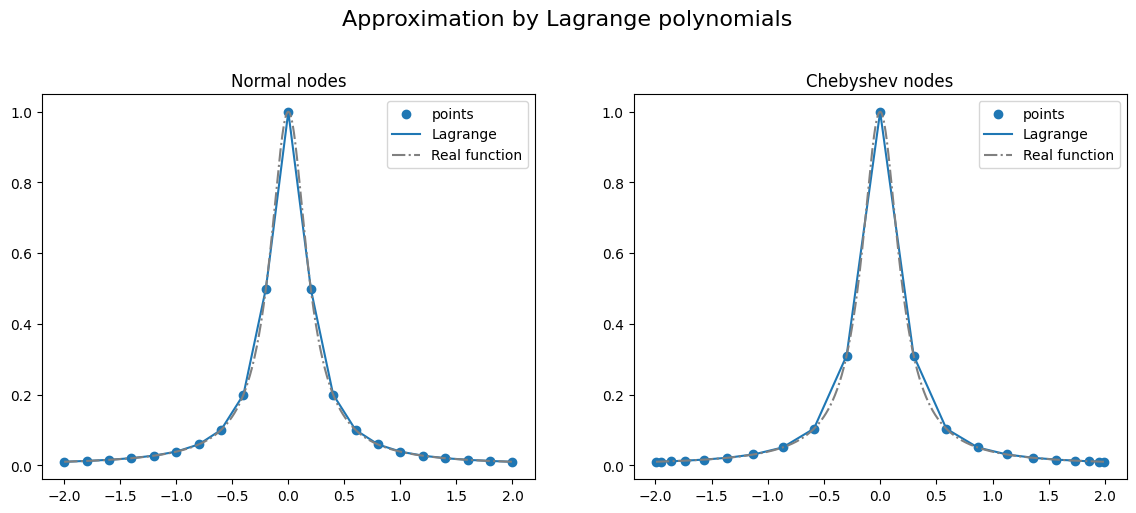

In [14]:
import math

x_normal = np.linspace(-2, 2, 21)
y_normal = f(x_normal)
L_normal = scipy.interpolate.interp1d(x_normal, y_normal)

n = 21
x_chebyshev = np.array([2*math.cos(np.pi*(2*k+1)/(2*n)) for k in range(n)])
y_chebyshev = f(x_chebyshev)
L_chebyshev = scipy.interpolate.interp1d(x_chebyshev, y_chebyshev)

plt.figure(figsize=(14, 5))
plt.suptitle('Approximation by Lagrange polynomials', fontsize=16, y=1.05)

plt.subplot(1, 2, 1)
plt.title('Normal nodes')
plt.scatter(x_normal, y_normal, label="points")
x_plot = np.linspace(min(x_normal), max(x_normal), 1000)
plt.plot(x_plot, L_normal(x_plot), label="Lagrange")
plt.plot(x_plot, f(x_plot), label="Real function", linestyle='-.', color='gray')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('Chebyshev nodes')
plt.scatter(x_chebyshev, y_chebyshev, label="points")
x_plot = np.linspace(min(x_chebyshev), max(x_chebyshev), 1000)
plt.plot(x_plot, L_chebyshev(x_plot), label="Lagrange")
plt.plot(x_plot, f(x_plot), label="Real function", linestyle='-.', color='gray')
plt.legend()
plt.show()

***Zadanie 4.***

Kierowca jadący z miasta A do miasta B, zauważywszy na drodze fotoradar, zaczął gwałtownie hamować. Przebieg jego położenia, zarejestrowany przez nawigację, pokazano w poniższej tabeli. Wiedząc, że radar znajduje się w punkcie o współrzędnej 79.6 m, oszacuj kiedy kierowca minął fotoradar (w tym celu skorzystaj z jednej z metod z laboratorium 3) oraz z jaką prędkością wtedy jechał (wykorzystaj relację drogi i prędkości znaną z fizyki). 

|czas \[s\]|położenie \[m\]|
|--|--|
|0.0|0.0|
|1.0|42.7|
|2.0|73.2|
|3.0|92.5|

In [58]:
from typing import Callable, Tuple, List

def bisect_method(f: Callable[[int], float], xa: float, xb: float, eps: float = 1e-10, max_iter: int = 100, prev_c: float = None, curr_iter: int = 1) -> float:
    if f(xa)*f(xb)>0:
        raise ValueError("Warunek startowy nie został spełniony")
    c = (xa+xb)/2
    if curr_iter > max_iter:
        print("ITERATION LIMIT")
        return c
    if f(c) == 0 or (prev_c and abs(c-prev_c)<=eps):
        return c
    elif (f(c) < 0 and f(xa) > 0) or (f(c) > 0 and f(xa) < 0):
        # xb <- c
        return bisect_method(f, xa, c, prev_c=c, curr_iter=curr_iter+1)
    else: # f(c) < 0
        # xa <- c
        return bisect_method(f, c, xb, prev_c=c, curr_iter=curr_iter+1)

x_0:  2.2758469402906485
m(x_0):  79.59999999966367
v(x_0):  21.68189336931191


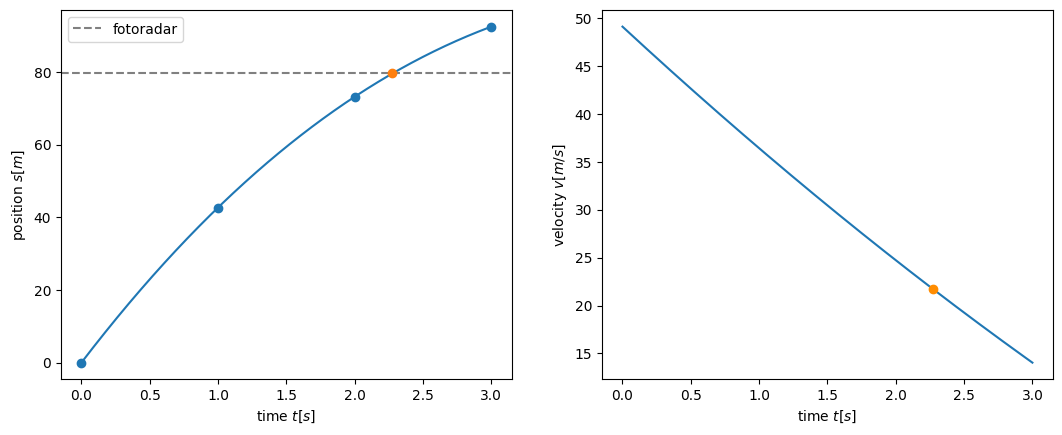

In [100]:
FOTORADAR = 79.6

t = [0.0, 1.0, 2.0, 3.0]
s = [0.0, 42.7, 73.2, 92.5]

spl = scipy.interpolate.CubicSpline(t, s)
L = scipy.interpolate.lagrange(t, s)

x_plot = np.linspace(0, 3, 1000)
y_plot = L(x_plot)

L_moved = L - FOTORADAR

x_0 = bisect_method(L_moved, 2, 3)
print('x_0: ', x_0)
print('m(x_0): ', spl(x_0))
print('v(x_0): ', spl(x_0, nu=1))

plt.figure(figsize=(6.4*2, 4.8))
plt.subplot(1, 2, 1)
plt.xlabel('time $t [s]$')
plt.ylabel('position $s [m]$')
plt.scatter(t, s)
plt.scatter(x_0, L(x_0), zorder=4)
plt.axhline(FOTORADAR, color='gray', label='fotoradar', linestyle='--')
plt.plot(x_plot, spl(x_plot))
plt.legend()

plt.subplot(1, 2, 2)
plt.xlabel('time $t [s]$')
plt.ylabel('velocity $v [m/s]$')
plt.scatter(x_0, spl(x_0, nu=1), zorder=4, color='darkorange')
plt.plot(x_plot, spl(x_plot, nu=1))
plt.show()

**Zadanie dla zainteresowanych programowaniem funkcyjnym w Pythonie**

Stwórz funkcję znajdującą wielomian interpolacyjny metodą Lagrange'a. Funkcja powinna przyjmować dwie listy:
* listę argumentów ($x$-ów)
* listę wartości ($y$-ów).  


Po wykonaniu obliczeń funkcja powinna zwracać wielomian w postaci obiektu typu **funkcja** (a nie `numpy.Polynomial`).

**Wskazówka** Wykorzystaj wyrażenia *lambda*. Dla ułatwienia możesz się też posłużyć pakietami `operator` i `functools`.
